In [15]:
#optional installations: 
#!pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [16]:
# ___variables___
#ticker = 'MSFT'
#ticker = 'AAPL'
ticker = 'UBER'
#ticker = 'TWTR'

start_time = datetime.datetime(2017, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [17]:
# yahoo gives only daily historical data
connected = False
while not connected:
    try:
        df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
        connected = True
        print('connected to yahoo')
    except Exception as e:
        print("type error: " + str(e))
        time.sleep( 5 )
        pass   

# use numerical integer index instead of date    
df = df.reset_index()
print(df.head(5))

connected to yahoo
        Date       High        Low       Open      Close     Volume  Adj Close
0 2019-05-10  45.000000  41.060001  42.000000  41.570000  186322500  41.570000
1 2019-05-13  39.240002  36.080002  38.790001  37.099998   79442400  37.099998
2 2019-05-14  39.959999  36.849998  38.310001  39.959999   46661100  39.959999
3 2019-05-15  41.880001  38.950001  39.369999  41.290001   36086100  41.290001
4 2019-05-16  44.060001  41.250000  41.480000  43.000000   38115500  43.000000


In [18]:
def bollinger_bands(df, n, m):
    # takes dataframe on input
    # n = smoothing length
    # m = number of standard deviations away from MA
    
    #typical price
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    # but we will use Adj close instead for now, depends
    
    data = TP
    #data = df['Adj Close']
    
    # takes one column from dataframe
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std() 
    
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [19]:
n = 20   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(df, 20, 2)

In [20]:
print(df.head())
print(df.tail())

        Date       High        Low       Open      Close     Volume  Adj Close  B_MA  BU  BL
0 2019-05-10  45.000000  41.060001  42.000000  41.570000  186322500  41.570000   NaN NaN NaN
1 2019-05-13  39.240002  36.080002  38.790001  37.099998   79442400  37.099998   NaN NaN NaN
2 2019-05-14  39.959999  36.849998  38.310001  39.959999   46661100  39.959999   NaN NaN NaN
3 2019-05-15  41.880001  38.950001  39.369999  41.290001   36086100  41.290001   NaN NaN NaN
4 2019-05-16  44.060001  41.250000  41.480000  43.000000   38115500  43.000000   NaN NaN NaN
          Date       High        Low       Open      Close    Volume  Adj Close       B_MA         BU         BL
755 2022-05-09  26.065001  22.799999  25.410000  23.049999  58095900  23.049999  30.769083  35.997928  25.540238
756 2022-05-10  24.549999  22.799999  23.850000  23.670000  47982500  23.670000  30.355417  36.432283  24.278550
757 2022-05-11  24.150000  22.500000  23.280001  22.570000  51137700  22.570000  29.895833  36.710174  

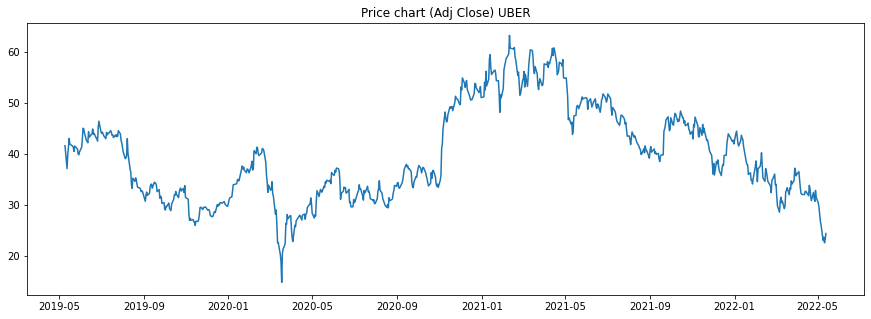

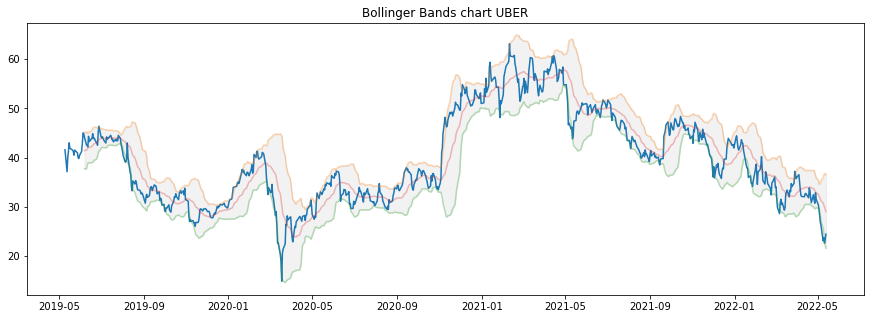

In [21]:
# plot price
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Price chart (Adj Close) ' + str(ticker))
plt.show()

# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('Bollinger Bands chart ' + str(ticker))
plt.plot(df['Date'], df['Adj Close'])
plt.plot(df['Date'], df['BU'], alpha=0.3)
plt.plot(df['Date'], df['BL'], alpha=0.3)
plt.plot(df['Date'], df['B_MA'], alpha=0.3)
plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

plt.show()

In [22]:
#### RESAMPLING TO WEEKLY TO CLEAN NOISE

agg_dict = {'Open': 'first',
          'High': 'max',
          'Low': 'min',
          'Close': 'last',
          'Adj Close': 'last',
          'Volume': 'mean'}

# resampled dataframe
# 'W' means weekly aggregation
df.set_index('Date', inplace=True)
df_agg = df.resample('W').agg(agg_dict)
df_agg = df_agg.reset_index()

In [23]:
# add BB columns
n = 20   # datapoint rolling window
m = 2    # sigma width
df_agg = bollinger_bands(df_agg, 20, 2)

In [24]:
def add_signal(df):
    # adds two columns to dataframe with buy and sell signals
    buy_list = []
    sell_list = []
    
    for i in range(len(df['Close'])):
        #if df['Close'][i] > df['BU'][i]:           # sell signal     daily
        if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        #elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
        elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [25]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df['Date'], df['Adj Close'])
    plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close')

    plt.plot(df['Date'], df['High'], label='High', alpha=0.3)
    plt.plot(df['Date'], df['Low'], label='Low', alpha=0.3)

    plt.plot(df['Date'], df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df['Date'], df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df['Date'], df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df['Date'], df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df['Date'], df['Buy'], label='Buy', marker='^')
    plt.scatter(df['Date'], df['Sell'], label='Sell', marker='v')

    plt.legend()

    plt.show()

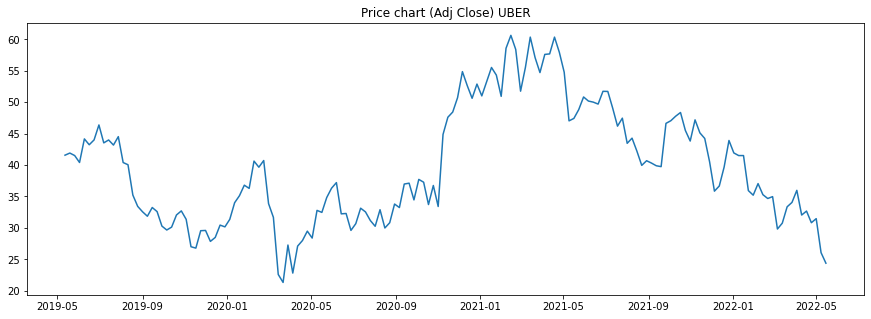

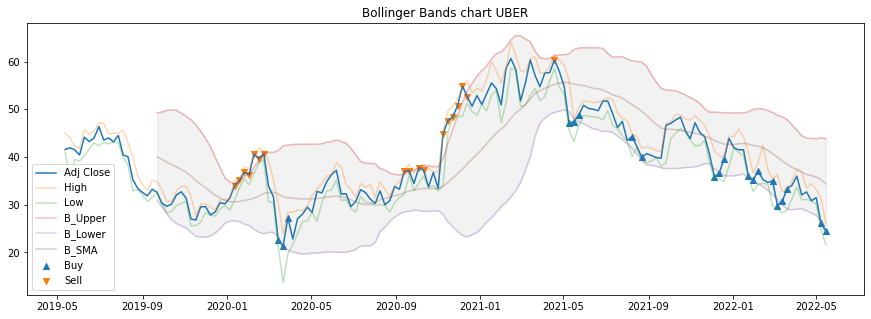

In [26]:
df_agg = add_signal(df_agg)
plot_signals(df_agg, ticker)